# Modeling HIV infection

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

During the initial phase of HIV infection, the concentration of the virus in the bloodstream typically increases quickly and then decreases.
The most obvious explanation for the decline is an immune response that destroys the virus or controls its replication.
However, at least in some patients, the decline occurs even without any detectable immune response.

In 1996 Andrew Phillips proposed another explanation for the decline ("Reduction of HIV Concentration During Acute Infection: Independence from a Specific Immune Response", available from <https://people.math.gatech.edu/~weiss/uploads/5/8/6/1/58618765/phillips1996.pdf>).

Phillips presents a system of differential equations that models the concentrations of the HIV virus and the CD4 cells it infects.
The model does not include an immune response; nevertheless, it demonstrates behavior that is qualitatively similar to what is seen in patients during the first few weeks after infection.

His conclusion is that the observed decline in the concentration of HIV might not be caused by an immune response; it could be due to the dynamic interaction between HIV and the cells it infects.

In this notebook, we'll implement Phillips's model and consider whether it does the work it is meant to do.

## The Model

The model has four state variables, `R`, `L`, `E`, and `V`.  Read the paper to understand what they represent.

Here are the initial conditional we can glean from the paper. 

In [2]:
init = modsim.State(R=200, L=0, E=0, V=4e-7)

The behavior of the system is controlled by 9 parameters.
That might seem like a lot, but they are not entirely free parameters; their values are constrained by measurements and background knowledge (although some are more constrained than others).
Here are the values from Table 1.

Note: the parameter $\rho$ (the Greek letter "rho") in the table appears as $p$ in the equations.  Since it represents a proportion, we'll use $p$.

In [9]:
gamma = 1.36
mu = 1.36e-3
tau = 0.2
beta = 0.00027
p = 0.1
alpha = 3.6e-2
sigma = 2
delta = 0.33
pi = 100

Here's a `System` object with the initial conditions and the duration of the simulation (120 days).
Normally we would store the parameters in the `System` object, but the code will be less cluttered if we leave them as global variables.

In [4]:
system = modsim.System(init=init, t_end=120, num=481)

**Exercise:** Use the equations in the paper to write a slope function that takes a `State` object with the current values of `R`, `L`, `E`, and `V`, and returns their derivatives in the corresponding order.

In [10]:
# Solution goes here
def slope_func(t, state, system):
    R, L, E, V = state
    
    betaRV = beta*R*V

    dRdt = gamma*tau - mu*R - betaRV
    dLdt = p*betaRV - L*(mu - alpha)
    dEdt = (1 - p)*betaRV + alpha*L - delta*E
    dVdt = pi*E - sigma*V

    return dRdt, dLdt, dEdt, dVdt

Test your slope function with the initial conditions.
The results should be approximately

```
-2.16e-08, 2.16e-09, 1.944e-08, -8e-07
```

In [11]:
# Solution goes here
slope_func(0, init, system)

(-2.1599999999999998e-08, 2.16e-09, 1.9439999999999997e-08, -8e-07)

**Exercise:** Now use `run_solve_ivp` to simulate the system of equations.

In [12]:
# Solution goes here
results, details = modsim.run_solve_ivp(system, slope_func)

In [14]:
# Solution goes here
print(details.message)
results.head()

The solver successfully reached the end of the integration interval.


,R,L,E,V
0.00,200.0,0.000000e+00,0.000000e+00,4.000000e-07
0.25,200.0,4.485688e-10,3.850906e-09,2.861171e-07
0.50,200.0,1.137676e-09,9.881299e-09,7.776679e-08
0.75,200.0,2.561176e-09,2.296161e-08,-5.289791e-07
1.00,200.0,3.310851e-09,2.888518e-08,-5.789243e-07


The next few cells plot the results on the same scale as the figures in the paper.

**Exericise:** Compare your results to the results in the paper.
Are they consistent?

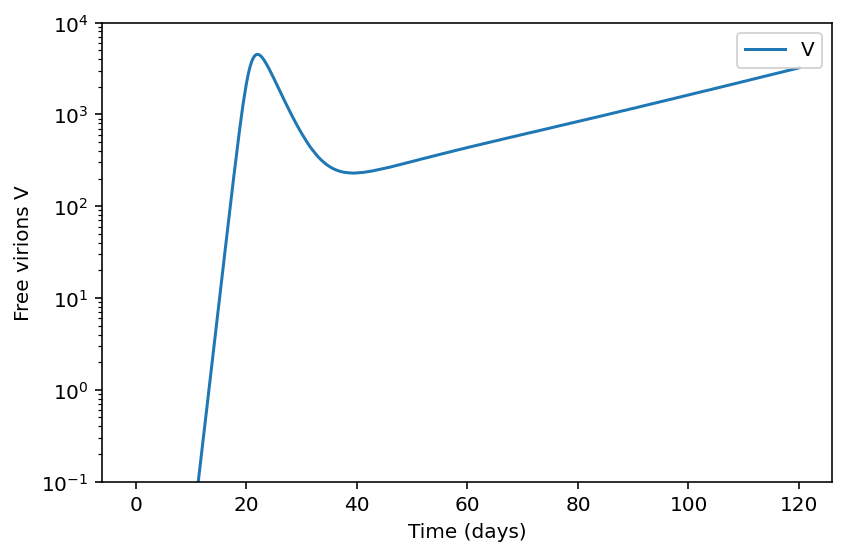

In [15]:
results.V.plot(label='V')
modsim.decorate(
    xlabel='Time (days)',
    ylabel='Free virions V',
    yscale='log',
    ylim=[0.1, 1e4],
)

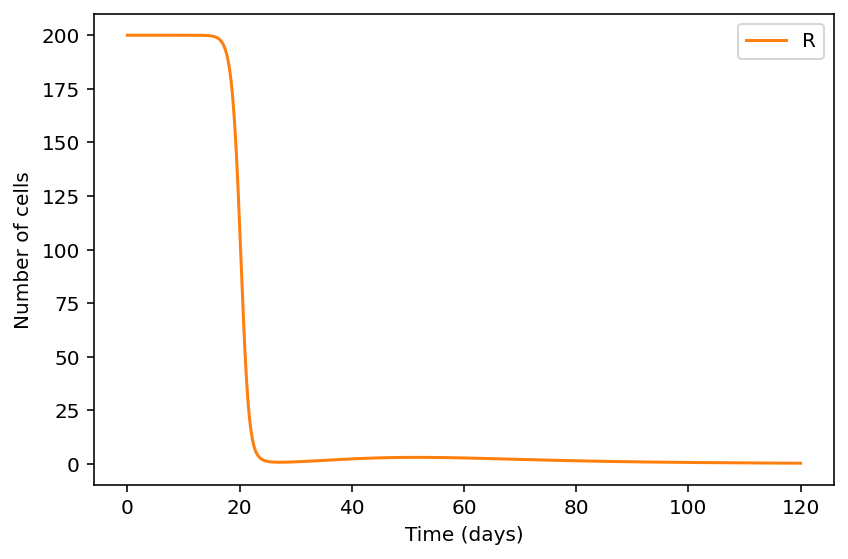

In [16]:
results.R.plot(label='R', color='C1')
modsim.decorate(
    xlabel='Time (days)',
    ylabel='Number of cells',
)

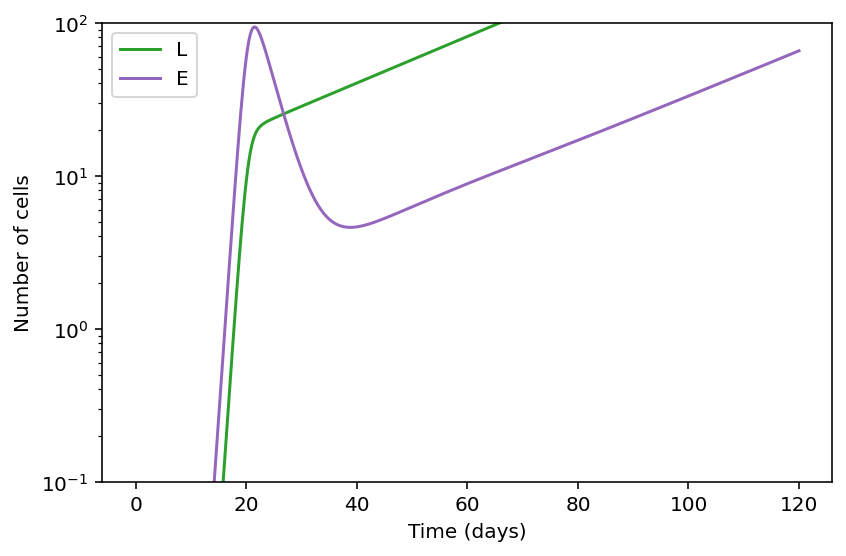

In [17]:
results.L.plot(color='C2', label='L')
results.E.plot(color='C4', label='E')
modsim.decorate(
    xlabel='Time (days)',
    ylabel='Number of cells',
    yscale='log',
    ylim=[0.1, 100],
)

**Exercise:** What kind of work is this model doing?  Do you find the results convincing?  What are the strengths of the model?  What are the weaknesses?

**Exercise:** Read [this response to Phillips's article](https://science.sciencemag.org/content/sci/272/5270/1960.full.pdf) and Phillips's response to the response.  What do you think of the arguments on both sides.  Do you think the model Phillips proposed is sufficient to make his argument, or do you think it leaves out essential features of the real world?